# Mini-Project 3: Viral prediction

Date: 2020.12.17

Author: © 2020 Dovile Komolovaite

Template author: © 2020 [Mantas Lukoševičius](https://mantas.info/)

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

You should only eddit this notebook where it is allowed, comment on all of your improvements in markdown cells and in your presentation.

Here we analyze open COVID-19 data from https://ourworldindata.org/coronavirus.

## Load the data

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
## Install sktime library for forecasting models
!pip install sktime

Download the data to cache locally. Do this once (a day), and comment out again, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [4]:
#'''
import requests
fname = 'owid-covid-data.csv'
url = 'https://covid.ourworldindata.org/data/' + fname
r = requests.get(url)
open(fname, 'wb').write(r.content)
#''';

13409555

Load the file to Pandas.

In [5]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

The time series to predict.

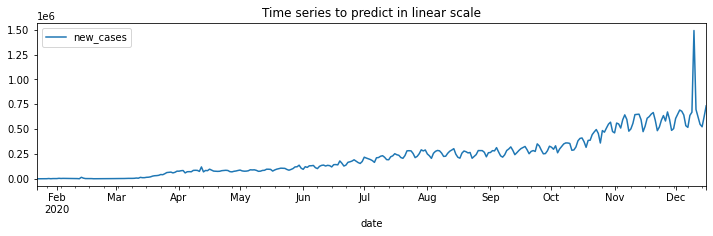

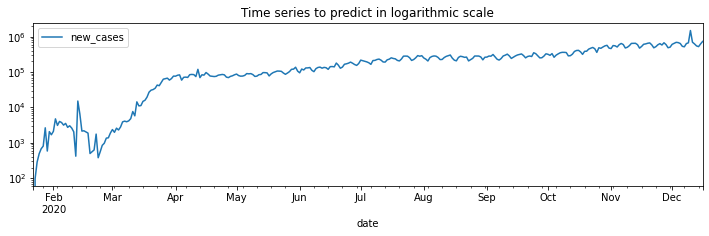

In [6]:
column = 'new_cases'
time_series = df[df.iso_code=='OWID_WRL'][['date',column]].set_index('date')
# linear scale:
time_series.plot(figsize=(12,3),logy=False)
plt.title('Time series to predict in linear scale')
plt.show()
# log scale:
time_series.plot(figsize=(12,3),logy=True)
plt.title('Time series to predict in logarithmic scale')
plt.show()

Use data only from April 2020:

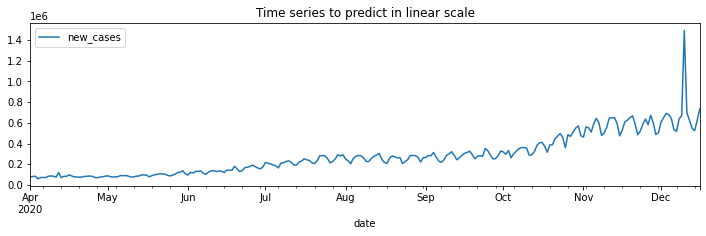

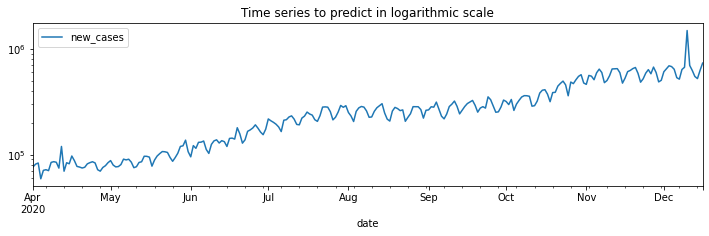

In [7]:
cut_date_from = datetime.strptime('2020-04-01', "%Y-%m-%d")
time_series = time_series[cut_date_from:]
# plot data to work with:
# linear scale:
time_series.plot(figsize=(12,3),logy=False)
plt.title('Time series to predict in linear scale')
plt.show()
# log scale:
time_series.plot(figsize=(12,3),logy=True)
plt.title('Time series to predict in logarithmic scale')
plt.show()

Error measure used to evaluate your solution is Root Mean Square Log Error (RMSLE), square-root of 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error.

In [8]:
from sklearn.metrics import mean_squared_log_error
def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

Split the data into training and testing. You can temporality fix the dates in your experiments.

In [9]:
from datetime import timedelta
# last_date will be 2020-12-23 in final testing, and other dates set accordingly 
last_semester_date = pd.Timestamp('2020-12-11')
last_date = time_series.index[-1]
if last_date >= last_semester_date:
    last_date = last_semester_date #  # 
    print("We can test now!")
# will be 2020-12-16 - the last date available before your dedline: end of 2020-12-17
last_training_date = last_date - timedelta(days=7) 
first_prediction_date = last_date - timedelta(days=6)
last_prediction_date = last_date
(last_training_date, first_prediction_date, last_prediction_date)

We can test now!


(Timestamp('2020-12-04 00:00:00'),
 Timestamp('2020-12-05 00:00:00'),
 Timestamp('2020-12-11 00:00:00'))

In [10]:
training_time_series = time_series[:last_training_date]
testing_time_series = time_series[first_prediction_date:last_prediction_date]
print(f'training data size: {len(training_time_series)}, testing data size: {len(testing_time_series)}')

training data size: 248, testing data size: 7


# My models

**This is the only section which you should rewrite and expand significanlty providing/documenting your models tried and results with them. **

Give links to the sources of the models and the ideas!

Execution of this section should not take long (no training here ;).

## A simple persistency model 

Returns the last week as the prediction for the next one. 

Validation MRSLE with last_date=2020-12-07 is 0.07974867401899698. Training time: negligible. No hyper parameter optimization tried.

In [11]:
def get_last_week(train_data):
    return train_data[-7:]

## Standard Facebook Prophet prediction library

Taken from https://facebook.github.io/prophet/.

Validation MRSLE with last_date=2020-12-07 is 0.11099341341289806. Training time: 1.55 ms on Colab . No hyper parameter optimization tried.

In [12]:
# Install a pip package in the current Jupyter kernel if it's not present (takes some time). It is
# It is present in Colab.
# from https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
# import sys
# !{sys.executable} -m pip install pystan
# !{sys.executable} -m pip install fbprophet
from fbprophet import Prophet
def use_fb_prophet(train_data):
    m = Prophet()
    # the data must have the specific columns
    a = train_data.reset_index()
    b = a.rename(columns={'date': 'ds', 'new_cases': 'y'})

    m.fit(b)
    prediction_dates = m.make_future_dataframe(periods=7, include_history=False) 
    prediction = m.predict(prediction_dates)
    # and be formated back
    return prediction.set_index('ds')['yhat']

## 0. Preprocessing - spike removal

The developed method checks the data of all weeks, calculates the difference between the highest and lowest value. And if that difference is greater than the set limit, it assumes that the maximum value is outlier, and replaces the value with the average of the adjacent values.

In [14]:
def check_for_spikes(time_series, threshold=500000.0):
  df = time_series.reset_index().copy()
  df['week_number'] = df['date'].dt.week  # dayofweek
  difference_between_max_and_min = df.groupby('week_number')['new_cases'].max() - df.groupby('week_number')['new_cases'].min()
  week_number_indexes = difference_between_max_and_min[difference_between_max_and_min > threshold]

  for idx in week_number_indexes.index:
    max_index = df[df['week_number']==idx]['new_cases'].idxmax()
    # change spike value to the averaged value between two days:
    df['new_cases'][max_index] = (df['new_cases'][max_index-1] + df['new_cases'][max_index+1])/2

  df.drop(columns=['week_number'], inplace=True)
  return df.set_index('date')

In [15]:
# training_time_series = check_for_spikes(training_time_series)
# testing_time_series = check_for_spikes(testing_time_series)

## 1. Naive model
Predicting values of the last week. Same as simple persistency model.

In [16]:
from sktime.forecasting.naive import NaiveForecaster

def Naive_model(train_data, log=True):
  if log:
      train_data = np.log(train_data)
  forecaster = NaiveForecaster(strategy="last", sp=7)
  forecaster.fit(train_data.reset_index()['new_cases'])
  # predict:
  start_predict_index = train_data.reset_index().index[-1]
  predict_for_dates = np.arange(start_predict_index, start_predict_index + 7, 1)
  predicted_time_series = forecaster.predict(predict_for_dates)
  if log:
    predicted_time_series = np.exp(predicted_time_series)
  # to dataframe:
  predicted_frame = pd.DataFrame(predicted_time_series, columns=['new_cases'])
  predicted_frame['date'] = np.arange(train_data.index[-1] + timedelta(days=1), 
                                      train_data.index[-1] + timedelta(days=8), 
                                      timedelta(days=1)).astype(datetime)
  return predicted_frame.set_index('date')

## 2. Exponential smoothing

Holt-Winters exponential smoothing forecaster. Model parameters are estimated  by maximizing the log-likelihood.

The method is suitable for univariate time series with trend and/or seasonal components.

In [18]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

def Exponential_smoothing(train_data, log=True):
  if log:
      train_data = np.log(train_data)
  forecaster = ExponentialSmoothing(optimized=True)
  forecaster.fit(train_data.reset_index()['new_cases'])
  # predict:
  start_predict_index = train_data.reset_index().index[-1]
  predict_for_dates = np.arange(start_predict_index, start_predict_index + 7, 1)
  predicted_time_series = forecaster.predict(predict_for_dates)
  if log:
    predicted_time_series = np.exp(predicted_time_series)
  # to dataframe:
  predicted_frame = pd.DataFrame(predicted_time_series, columns=['new_cases'])
  predicted_frame['date'] = np.arange(train_data.index[-1] + timedelta(days=1), 
                                      train_data.index[-1] + timedelta(days=8), 
                                      timedelta(days=1)).astype(datetime)
  return predicted_frame.set_index('date')

## 3.1. Detrend + Deseasonalize + ReducedRegressionForecaster

Use the Reduced Regression Forecaster, but remove seasonality and detrend your data beforehand.

In [20]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformers.single_series.detrend import Detrender
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformers.single_series.detrend import Deseasonalizer
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor

In [21]:
def Detrended_Deseasonalized_Regression_Forecaster(train_data, log=True):
  if log:
      train_data = np.log(train_data)
  regressor = KNeighborsRegressor(n_neighbors=1)
  forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="additive", sp=7)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=4))),
    ("forecast", ReducedRegressionForecaster(regressor=regressor, window_length=7, strategy="recursive"))
  ])
  forecaster.fit(train_data.reset_index()['new_cases'])
  # predict:
  start_predict_index = train_data.reset_index().index[-1]
  predict_for_dates = np.arange(start_predict_index, start_predict_index + 7, 1)
  predicted_time_series = forecaster.predict(predict_for_dates)
  if log:
    predicted_time_series = np.exp(predicted_time_series)
  # to dataframe:
  predicted_frame = pd.DataFrame(predicted_time_series, columns=['new_cases'])
  predicted_frame['date'] = np.arange(train_data.index[-1] + timedelta(days=1), 
                                      train_data.index[-1] + timedelta(days=8), 
                                      timedelta(days=1)).astype(datetime)
  return predicted_frame.set_index('date')

## 3.2. Deseasonalize + ReducedRegressionForecaster

In [23]:
def Deseasonalized_Regression_Forecaster(train_data, log=True):
  if log:
      train_data = np.log(train_data)
  regressor = KNeighborsRegressor(n_neighbors=1)
  forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="additive", sp=7)),
    ("forecast", ReducedRegressionForecaster(regressor=regressor, window_length=7, strategy="recursive"))
  ])
  forecaster.fit(train_data.reset_index()['new_cases'])
  # predict:
  start_predict_index = train_data.reset_index().index[-1]
  predict_for_dates = np.arange(start_predict_index, start_predict_index + 7, 1)
  predicted_time_series = forecaster.predict(predict_for_dates)
  if log:
    predicted_time_series = np.exp(predicted_time_series)
  # to dataframe:
  predicted_frame = pd.DataFrame(predicted_time_series, columns=['new_cases'])
  predicted_frame['date'] = np.arange(train_data.index[-1] + timedelta(days=1), 
                                      train_data.index[-1] + timedelta(days=8), 
                                      timedelta(days=1)).astype(datetime)
  return predicted_frame.set_index('date')

## 4. SARIMAX Model
Use Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model.

**Exogenous variables** are also called covariates and can be thought of as parallel input sequences that have observations at the same time steps as the original series. 
The method is suitable for univariate time series with trend and/or seasonal components and exogenous variables.

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

def SARIMAX_model(train_data, log=True):
  if log:
      train_data = np.log(train_data)
  arima_model = SARIMAX(train_data.reset_index()['new_cases'], order=(0, 2, 2), seasonal_order=(2, 0, 2, 12))
  arima_result = arima_model.fit(maxiter=100)
  # print(arima_result.summary())
  # predict:
  start_predict_index = train_data.reset_index().index[-1] + 1
  predicted_time_series = arima_result.predict(start = start_predict_index, end = start_predict_index + 6, typ="levels").rename("ARIMA Predictions")
  if log:
    predicted_time_series = np.exp(predicted_time_series)
  # to dataframe:
  predicted_frame = pd.DataFrame(predicted_time_series.values, columns=['new_cases'])
  predicted_frame['date'] = np.arange(train_data.index[-1] + timedelta(days=1), 
                                      train_data.index[-1] + timedelta(days=8), 
                                      timedelta(days=1)).astype(datetime)
  return predicted_frame.set_index('date')


def grid_search_SARIMAX_parameters(train_data, log=True):
  """Taken from: https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b"""
  p = d = q = range(0, 3)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  if log:
      train_data = np.log(train_data)
  for param in pdq:
    for param_seasonal in seasonal_pdq:
      try:
        mod = SARIMAX(train_data.reset_index()['new_cases'],
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
      except:
        continue

In [25]:
# select model parameters with the lowest AIC value:
# grid_search_SARIMAX_parameters(training_time_series, log=True)

In [26]:
# predicted_time_series = SARIMAX_model(training_time_series, log=True)
# predicted_time_series

## 5. SimpleRNN
Use deep learning method, but before using it - scale the data.

In [27]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import tensorflow as tf

In [28]:
def SimpleRNN_model(train_data, log=True, epochs=10):
  if log:
      train_data = np.log(train_data)
  # normalize data:
  scaler = MinMaxScaler()
  scaler.fit(train_data)
  scaled_train_data = scaler.transform(train_data)
  # transform the data into sequences of samples with input and output components:
  n_input = 7  # Take the 7 previous points
  n_features= 1  # Univeriate data
  generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
  # feed data into the RNN model:
  rnn_model = Sequential()
  rnn_model.add(SimpleRNN(200, input_shape = (n_input , n_features)))
  rnn_model.add(Dense(1))
  rnn_model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])
  rnn_model.fit_generator(generator=generator, epochs=epochs)
  # Recursively forecast new values:
  rnn_predictions_scaled = list()
  batch = scaled_train_data[-n_input:]
  current_batch = batch.reshape((1, n_input, n_features))
  for i in range(7):   
      rnn_pred = rnn_model.predict(current_batch)[0]
      rnn_predictions_scaled.append(rnn_pred) 
      current_batch = np.append(current_batch[:,1:,:],[[rnn_pred]],axis=1)
  # Reverse the scaling to get the original values again to compare with the true values:
  rnn_pred = scaler.inverse_transform(rnn_predictions_scaled)
  if log:
    rnn_pred = np.exp(rnn_pred)
  # to dataframe:
  predicted_frame = pd.DataFrame(rnn_pred, columns=['new_cases'])
  predicted_frame['date'] = np.arange(train_data.index[-1] + timedelta(days=1), 
                                      train_data.index[-1] + timedelta(days=8), 
                                      timedelta(days=1)).astype(datetime)
  return predicted_frame.set_index('date')

## 6. LSTM
The Long Short-Term Memory recurrent neural network.

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

In [30]:
from keras.layers import LSTM

def LSTM_model(train_data, log=True, epochs=10):
  if log:
      train_data = np.log(train_data)
  # normalize data:
  scaler = MinMaxScaler()
  scaler.fit(train_data)
  scaled_train_data = scaler.transform(train_data)
  # transform the data into sequences of samples with input and output components:
  n_input = 7  # Take the 7 previous points
  n_features= 1  # Univeriate data
  generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
  # train the model:
  lstm_model = Sequential()
  lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
  lstm_model.add(Dense(1))
  lstm_model.compile(optimizer='adam', loss='mse')
  lstm_model.fit_generator(generator,epochs=epochs)
  # Recursively forecast new values:
  lstm_predictions_scaled = list()
  batch = scaled_train_data[-n_input:]
  current_batch = batch.reshape((1, n_input, n_features))
  for i in range(7):   
      lstm_pred = lstm_model.predict(current_batch)[0]
      lstm_predictions_scaled.append(lstm_pred) 
      current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)
  # Reverse the scaling to get the original values again to compare with the true values:
  lstm_pred = scaler.inverse_transform(lstm_predictions_scaled)
  if log:
    lstm_pred = np.exp(lstm_pred)
  # to dataframe:
  predicted_frame = pd.DataFrame(lstm_pred, columns=['new_cases'])
  predicted_frame['date'] = np.arange(train_data.index[-1] + timedelta(days=1), 
                                      train_data.index[-1] + timedelta(days=8), 
                                      timedelta(days=1)).astype(datetime)
  return predicted_frame.set_index('date')

## Report

Validation types, variations and hyper parameters tried (last_date=2020.12.16):

The results can be presented in Tables like this:

| Variation or hyper-parameter values | Cross-Validation RMSLE | Validation RMSLE | Predicting time |
|-----------------------|-------------|----------|----------|
| Naive Model           |  0.162      |  0.136  |   0.01 ms   |
| Exponential smoothing |  0.15      |  0.142   |   0.01 ms   |
| Exponential smoothing with log data |   0.144     |  0.142   |    0.02 ms  |
| Detrended, Deseasonalized, Regression Forecaster with log data |   81.774   |   3.286   |  0.21 ms    |
| Deseasonalized, Regression Forecaster |   0.124    |  0.139     |  0.20 ms    |
| Deseasonalized, Regression Forecaster with log data |   0.117    |  0.139     |  0.22 ms    |
| **SARIMAX Model with log data** |   **0.093**      |   **0.054**   |  **5.94 ms**    |
| Simple RNN (20 epochs)  |  0.175      |  0.181    |   13.72 ms   |
| Simple RNN (100 epochs) |  0.124    |   0.03   |  66.41 ms    |
| LSTM Model (20 epochs)  |   0.141      | 0.053     |   33.00 ms   |
| LSTM Model (100 epochs)  |   0.115      |  0.062     |   162.73 ms   |



...

## My main best model

Was selected to be SARIMAX Model.


In [32]:
def my_best_method(train_data):
    train_data = check_for_spikes(train_data, threshold=500000.0)
    return SARIMAX_model(train_data, log=True)

## Validate  model visually

In [46]:
def plot_model_results(train_data, test_data, predict_data):
  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
  ax1.set_title('Forecasting results')
  train_data.plot(ax=ax1, color='blue')
  test_data.plot(ax=ax1, color='green')
  predict_data.plot(ax=ax1, color='red')
  ax1.legend(['trained data', 'tested data', 'predicted data'])
  # zoom in:
  train_data.plot(ax=ax2, color='blue')
  test_data.plot(ax=ax2, color='green')
  predict_data.plot(ax=ax2, color='red')
  ax2.set_xlim([test_data.reset_index()['date'][0] - timedelta(days=14), test_data.reset_index()['date'][6]])
  ax2.legend(['trained data', 'tested data', 'predicted data'])
  plt.show()

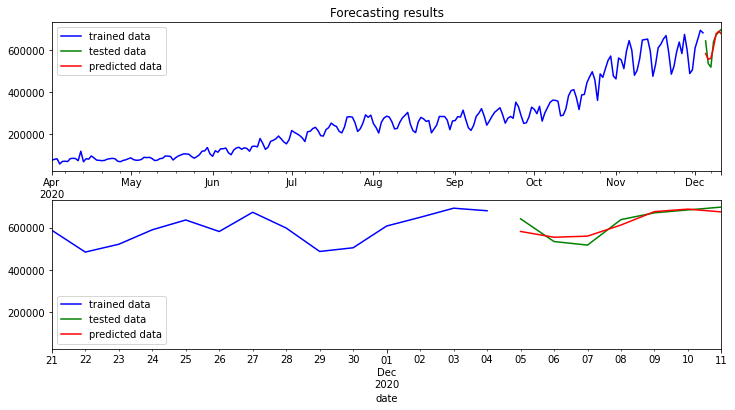

In [47]:
predicted_time_series = my_best_method(training_time_series)
plot_model_results(training_time_series, testing_time_series, predicted_time_series)

# Time Series cross-validator

Use time-based splitting to provide statistically robust model evaluation and best simulate real-life scenarios. 
This is similar to the “sliding window” training approach

In [35]:
from sklearn.model_selection import TimeSeriesSplit

def cross_validation(train_data, n_splits=31, plot=True):
  X = train_data.reset_index()

  tscv = TimeSeriesSplit(n_splits=n_splits)
  cros_validation_scores = []
  trained_data_lengths = []

  for train_index, test_index in tscv.split(X):
    # print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    trained_data_lengths.append(len(train_index))
    # model:
    predicted_time_series = my_best_method(X_train.set_index('date'))
    # evaluation:
    score = RMSLE(X_test.set_index('date'), predicted_time_series)
    cros_validation_scores.append(score)

  if plot:
    plt.figure(figsize=(8,4))
    plt.plot(trained_data_lengths, cros_validation_scores, color='blue')
    plt.plot(trained_data_lengths[22:], cros_validation_scores[22:], color='red', label='last 3 months')
    plt.title('Cross validation RMSL error scores for different samples')
    plt.legend()
    plt.xlabel('Trained Data Length')
    plt.ylabel('Root Mean Square Log Error')
    plt.show()

  print('Measure the average RMSLE value only for the last three months for the period from 2020-09-04 to get the final result.')
  print(f'cross validation score: {round(np.mean(cros_validation_scores[22:]),3)}')

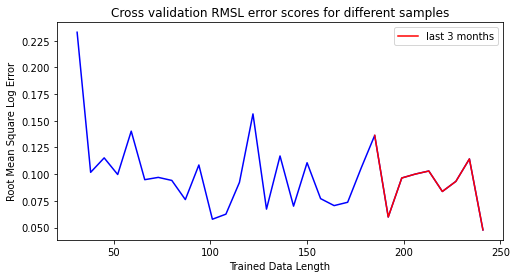

Measure the average RMSLE value only for the last three months for the period from 2020-09-04 to get the final result.
cross validation score: 0.093


In [36]:
# Change n_splits input, so that the length of test data would be == 7 (1 week)
cross_validation(training_time_series, n_splits=31, plot=True)

# Testing / validation

Do not edit beyound this point!

Run the training and prediction with your best model:

In [37]:
import time
start_time = time.time()

predicted_time_series = my_best_method(training_time_series)

end_time = time.time()
elapsed_time = end_time - start_time
max_training_time = 3*60
print('Predicting time: %.2f ms (max %i ms.)' %(elapsed_time,max_training_time))  
assert elapsed_time <= max_training_time, 'Training is too long!'

Predicting time: 5.65 ms (max 180 ms.)


In [38]:
predicted_time_series

,new_cases
date,
2020-12-05,582034.748045
2020-12-06,554637.140546
2020-12-07,559855.368678
2020-12-08,612568.894217
2020-12-09,676106.720022
2020-12-10,687837.922815
2020-12-11,674708.648387


Compute the error of your best model:

In [45]:
RMSLE(testing_time_series, predicted_time_series)

0.05360431421205642

## Information on the obtained hardware

Only relavant if execution time is in question: then it is tested on Colab T100 node, just as in MP2.

In [40]:
import os
osname = os.name
print(osname)
if osname == 'posix':
    f = os.popen('nvidia-smi')
    print(f.read())

    f = os.popen('lscpu')
    print(f.read())
elif osname == 'nt':
    # from https://winaero.com/get-cpu-information-via-command-prompt-in-windows-10/
    f = os.popen('wmic cpu get caption, deviceid, name, numberofcores, maxclockspeed, status')
    print(f.read())

posix
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.


Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_k